# Introduction


In this notebook, I use Gensim's LDA model for topic modelling on the 20Newsgroups Dataset

In [2]:
%matplotlib inline


LDA Model
=========



In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The purpose of this assignment is to demonstrate training an LDA model and
obtaining good results.

In this notebook I will:

* Load data.
* Pre-process data.
* Transform documents to a vectorized form.
* Train an LDA model.



Data -The 20Newsgroups Dataset
----

I will be making use of the 20-Newsgroups dataset for this topic modelling assignment. This version of the dataset contains about 11,000 newsgroups posts from 20 different topics and is available in the json format. 

The link for the dataset was obtained from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. The code for reading the json file was also borrowed from the same website.

Qualitatively evaluating the output of an LDA model is challenging and can require you to understand the
subject matter of your corpus (depending on your goal with the model). I believe that with the 20Newsgroups dataset with its vastly different topics, it would be easier to understand the topics learnt by the LDA model and to better evaluate its "accuracy".

.. Important::
    The corpus contains 11314 documents, and not particularly long ones.

Importing some important packages before reading the dataset

In [32]:
import nltk
import pandas as pd

In [15]:
# Import Dataset
newsgroups_df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(newsgroups_df.target_names.unique())
newsgroups_df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [16]:
newsgroups_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       11314 non-null  object
 1   target        11314 non-null  int64 
 2   target_names  11314 non-null  object
dtypes: int64(1), object(2)
memory usage: 353.6+ KB


We can see from the imported dataset that it contains 11314 documents. The dataset also contains the class labels which we will not be using for the LDA topic modelling. Hence, this will be an unsupervised learning.

Extracting the contents only to a list and removing the email-ids, newline characters and single quotes as a preliminary pre-processing/cleaning step

In [34]:
# Convert to list
docs = newsgroups_df.content.values.tolist()

# Remove Emails
docs = [re.sub('\S*@\S*\s?', '', email) for email in docs]

# Remove new line characters
docs = [re.sub('\s+', ' ', email) for email in docs]

# Remove distracting single quotes
docs = [re.sub("\'", "", email) for email in docs]

Displaying the content of the first document in the list as a sample

In [35]:
print(len(docs))
print(docs[0][0:500])
raw_docs = docs.copy()

11314
From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs


Pre-processing the documents
---------------------------------------

As part of preprocessing, I will:

* Tokenize the documents(split the documents into tokens).
* Lemmatize the tokens (converting tokens to their base forms - eg: troubled and troubling to trouble.
* Compute bigrams (2-word sequence of words which occur frequently).
* Compute a bag-of-words representation of the data (the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order).

First I tokenized the text using a regular expression tokenizer from NLTK. I
removed numeric tokens and tokens that are only a single character, as they
don't tend to be useful and doesn't help the model understand anything new about the documents 
or the topics.


In [36]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [38]:
import string

In [39]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].translate(str.maketrans('', '', string.punctuation)) #remove punctuations
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

I used the WordNet lemmatizer from NLTK for the next step. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling. 

Lemmatizer would convert troubled to trouble while a stemmer would convert the same token to troubl

In [40]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/sandeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

Next removing the stopwords from the documents. Stopwords do not lend any
more information to the model.

In [43]:
#remove stopwords
from gensim.utils import simple_preprocess

docs = [[token for token in simple_preprocess(str(doc)) if token not in stop_words] for doc in docs]

Next I find the bigrams in the documents. Bigrams are 2-word sequences.
Using bigrams we can get phrases like "supreme_court" in our output
(spaces are replaced with underscores); without bigrams we would only get
"supreme" and "court".

In the code below, I find bigrams and then add them to the
original data, because I would like to keep the words "supreme" and
"court" as well as the bigram "supreme_court".

Computing n-grams of large dataset can be very computationally and memory intensive.




In [44]:
#!pip3 install gensim
from gensim.models import Phrases

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            #If token is a bigram, add to document.
            docs[idx].append(token)

2022-08-04 13:25:38,790 : INFO : collecting all words and their counts
2022-08-04 13:25:38,792 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-08-04 13:25:41,466 : INFO : PROGRESS: at sentence #10000, processed 1516749 words and 927293 word types
2022-08-04 13:25:41,808 : INFO : collected 1011480 token types (unigram + bigrams) from a corpus of 1704643 words and 11314 sentences
2022-08-04 13:25:41,809 : INFO : merged Phrases<1011480 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2022-08-04 13:25:41,810 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1011480 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 3.02s', 'datetime': '2022-08-04T13:25:41.810080', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


I next removed rare words and common words based on their *document frequency*.
The below code removes words that appear in less than 100 documents or in more than
50% of the documents. This is because rare words effectively act as noise during LDA
whereas common words which appear in most documents do not help us learn anything new.



In [45]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 100 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=100, no_above=0.5)

2022-08-04 13:26:29,306 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-08-04 13:26:31,702 : INFO : adding document #10000 to Dictionary(87768 unique tokens: ['addition', 'anyone', 'body', 'bricklin', 'brought']...)
2022-08-04 13:26:31,990 : INFO : built Dictionary(96038 unique tokens: ['addition', 'anyone', 'body', 'bricklin', 'brought']...) from 11314 documents (total 1797697 corpus positions)
2022-08-04 13:26:31,991 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(96038 unique tokens: ['addition', 'anyone', 'body', 'bricklin', 'brought']...) from 11314 documents (total 1797697 corpus positions)", 'datetime': '2022-08-04T13:26:31.991808', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-08-04 13:26:32,151 : INFO : discarding 93941 tokens: [('bricklin', 4), ('bumper', 33), ('enlighten', 27), ('funky', 7), ('lerxst', 2), ('line', 11282), ('marylan

Finally, I transformed the documents to a vectorized form. The below code computes
the frequency of each word, including the bigrams.


In [46]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

Checking the number of words and documents available after the preprocessing


In [47]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2097
Number of documents: 11314


Training
--------

After pre-processing, the dataset is ready to be trained by
the LDA model. 
Explaining the thought process behind the selection of
the training parameters. 

The explanations for the parameters have been taken from https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html.

First of all: how many topics do I need? For most unsupervised dataset, there is 
no straightforward answer. However, in this case, with the 20Newsgroups dataset,
it is easy to set the number of topics to 20 because of prior knowledge. But instead 
of doing that, I have first created a cross validation function to check the model performance
with differnt number of topics. On that basis of that, I will set the number of topics.
I will first check how the model interprets the topics and if I can comprehend it and 
match it with what was expected. And later I will try to play around with
different topic numbers to find the ideal fit. It is possible that with higher topic 
numbers, the LDA could find subtopics within each of the 20Newsgroups topics.


``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set 
``chunksize =2000``, which is one-fifth the amount of documents, so all the
data takes 5-6 goes to completely process. Chunksize can however influence the quality of the model.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.


I have set ``alpha = 'auto'`` and ``eta = 'auto'``. Instead of specifying the parameters explicitly,
I am letting the model learn it automatically.


In [79]:
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Not evaluating model perplexity, since it takes too much time.

Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics

In [73]:
#cross validation function to check model coherance for different topic numbers
def ideal_topic_number(dictionary, corpus, texts, limit, start=2, step=3):
    """
    
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every
        )
        #saving models to a list
        model_list.append(model)
        
        #getting coherance values
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #saving it to a list
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Implementing the function above and getting the models and their coherance scores for plotting purposes

In [74]:
model_list, coherence_values = ideal_topic_number(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)

2022-08-04 14:29:35,092 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2022-08-04 14:29:35,097 : INFO : using serial LDA version on this node
2022-08-04 14:29:35,101 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 11314 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-08-04 14:29:35,171 : INFO : PROGRESS: pass 0, at document #2000/11314
2022-08-04 14:29:44,813 : INFO : optimized alpha [0.58136076, 0.51720124]
2022-08-04 14:29:44,815 : INFO : merging changes from 2000 documents into a model of 11314 documents
2022-08-04 14:29:44,819 : INFO : topic #0 (0.581): 0.015*"wa" + 0.009*"would" + 0.008*"one" + 0.007*"people" + 0.007*"ha" + 0.006*"article" + 0.006*"dont" + 0.006*"know" + 0.005*"get" + 0.005*"like"
2022-08-04 14:29:44,821 : INFO : topic #1 (0.517): 0.012*"wa" + 0.008*"one" + 0.008*"would" + 0.007*"article" + 0.007*"h

In [76]:
import matplotlib.pyplot as plt

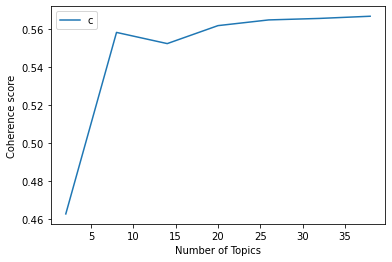

In [80]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Looking at the graph, it looks like the coherance score initially peaks at 8 topics and then it reduces before reaching
a high at 20 topics and then flattening out. We can see the same from the output below.

In [78]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4628
Num Topics = 8  has Coherence Value of 0.5582
Num Topics = 14  has Coherence Value of 0.5523
Num Topics = 20  has Coherence Value of 0.5618
Num Topics = 26  has Coherence Value of 0.5648
Num Topics = 32  has Coherence Value of 0.5656
Num Topics = 38  has Coherence Value of 0.5667


Now using the topic number = 20 to create the LDA model for visualizations

In [48]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

2022-08-04 13:27:29,618 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2022-08-04 13:27:29,621 : INFO : using serial LDA version on this node
2022-08-04 13:27:29,628 : INFO : running online (multi-pass) LDA training, 20 topics, 20 passes over the supplied corpus of 11314 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-08-04 13:27:29,629 : INFO : PROGRESS: pass 0, at document #2000/11314
2022-08-04 13:27:35,664 : INFO : optimized alpha [0.041450653, 0.04340837, 0.04136219, 0.039043814, 0.042006113, 0.040073104, 0.040459692, 0.04315086, 0.039800905, 0.041330896, 0.042920932, 0.039226852, 0.040706564, 0.039017476, 0.04085593, 0.041395176, 0.040589854, 0.040713575, 0.043962203, 0.044788696]
2022-08-04 13:27:35,667 : INFO : merging changes from 2000 documents into a m

Saving model in model20.gensim



## Evaluating model performance

The intial training has been completed and we can compute the topic coherence
of each topic. The code underneath displays the average topic coherence and model perplexity.

In [56]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2022-08-04 13:50:22,034 : INFO : -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 11314 documents with 1097317 words
2022-08-04 13:50:22,039 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -6.8344842021576415


2022-08-04 13:50:22,725 : INFO : 1 batches submitted to accumulate stats from 64 documents (2553 virtual)
2022-08-04 13:50:22,756 : INFO : 2 batches submitted to accumulate stats from 128 documents (4808 virtual)
2022-08-04 13:50:22,779 : INFO : 3 batches submitted to accumulate stats from 192 documents (7564 virtual)
2022-08-04 13:50:22,793 : INFO : 4 batches submitted to accumulate stats from 256 documents (9034 virtual)
2022-08-04 13:50:22,804 : INFO : 5 batches submitted to accumulate stats from 320 documents (9035 virtual)
2022-08-04 13:50:22,814 : INFO : 6 batches submitted to accumulate stats from 384 documents (9406 virtual)
2022-08-04 13:50:24,444 : INFO : 8 batches submitted to accumulate stats from 512 documents (15610 virtual)
2022-08-04 13:50:24,460 : INFO : 9 batches submitted to accumulate stats from 576 documents (20331 virtual)
2022-08-04 13:50:24,497 : INFO : 10 batches submitted to accumulate stats from 640 documents (21025 virtual)
2022-08-04 13:50:24,522 : INFO : 1


Coherence Score:  0.5746399991144087


The code underneath prints the topics in order of topic coherence.


If you are familiar with the subject of the articles/the different 
newgroups in this dataset, you can
see that the topics below make some sense. However, there is substantial overlap between some topics,
others are hard to interpret, and most of them have at least some terms that
seem out of place.

In [81]:
top_topics = model.top_topics(corpus) #, num_words=20)
model.num_topics


model.print_topics( num_words=20)

2022-08-04 15:17:04,754 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-08-04 15:17:04,849 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-08-04 15:17:04,936 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-08-04 15:17:05,037 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-08-04 15:17:05,080 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2022-08-04 15:17:05,117 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2022-08-04 15:17:05,173 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2022-08-04 15:17:05,210 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2022-08-04 15:17:05,245 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2022-08-04 15:17:05,285 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2022-08-04 15:17:05,321 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2022-08-04 15:17:05

[(0,
  '0.053*"armenian" + 0.032*"turkish" + 0.022*"greek" + 0.019*"people" + 0.018*"turk" + 0.016*"armenia" + 0.015*"wa" + 0.011*"russian" + 0.011*"genocide" + 0.010*"soviet" + 0.010*"world" + 0.009*"government" + 0.009*"muslim" + 0.008*"plane" + 0.008*"army" + 0.008*"today" + 0.008*"history" + 0.008*"island" + 0.007*"population" + 0.007*"village"'),
 (1,
  '0.031*"god" + 0.014*"wa" + 0.014*"christian" + 0.013*"one" + 0.012*"jesus" + 0.010*"people" + 0.010*"say" + 0.008*"believe" + 0.008*"would" + 0.008*"bible" + 0.008*"doe" + 0.007*"ha" + 0.007*"church" + 0.007*"life" + 0.006*"religion" + 0.006*"atheist" + 0.006*"belief" + 0.006*"word" + 0.006*"faith" + 0.005*"think"'),
 (2,
  '0.058*"bike" + 0.042*"dod" + 0.030*"tm" + 0.022*"wa" + 0.021*"dog" + 0.021*"em" + 0.021*"ride" + 0.020*"mi" + 0.020*"ed" + 0.020*"motorcycle" + 0.019*"md" + 0.017*"pa" + 0.016*"riding" + 0.016*"el" + 0.014*"bmw" + 0.014*"st" + 0.014*"newssoftware" + 0.013*"vaxvms" + 0.013*"road" + 0.012*"canada"'),
 (3,
  '0.0

## Inferring Topic from Keywords



## Visualisation


Using the below code, I have built a visualization tool to easily view the different topics and the keywords for those topics

The bubbles represent what part of the dataset the topic takes up.

In [50]:
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

     |████████████████████████████████| 1.6 MB 4.0 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97737 sha256=b2f12527105d909c2b55f3d9633a109952aa82b4255b4a0af69b59a39192d86e
  Stored in directory: /Users/sandeep/Library/Caches/pip/wheels/59/70/ee/99a0df99d8b4a7b87c79640ebee0927c0f6ccff046e9cc2471
Successfully built pyLDAvis


/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \
/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/san

One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document.

The function below nicely aggregates this information in a presentable table.

In [57]:
def get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df



In [58]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)

/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_10735/151267662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_10735/151267662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [59]:
doc_topic_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,4,0.3457,"wa, one, said, time, day, back, didnt, would, ...",From: (wheres my thing) Subject: WHAT car is t...
1,17,0.2982,"drive, card, disk, scsi, driver, system, mac, ...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,19,0.3962,"dont, would, one, like, think, get, article, k...",From: (Thomas E Willis) Subject: PB questions....
3,5,0.3237,"nntppostinghost, article, university, distribu...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,19,0.4069,"dont, would, one, like, think, get, article, k...",From: (Jonathan McDowell) Subject: Re: Shuttle...


Find the most representative document for each topic
--------------------------

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document!

In [60]:
# Group top sentences under each topic
doc_topics_sorted_df = pd.DataFrame()

doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

for i, grp in doc_topic_df_grpd:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

doc_topics_sorted_df.reset_index(drop=True, inplace=True)
doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
doc_topics_sorted_df.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9837,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: As Armenians cel...
1,1,0.9860,"god, wa, christian, one, jesus, people, say, b...",From: (Carol Alvin) Subject: Re: The arrogance...
2,2,0.9884,"bike, dod, tm, wa, dog, em, ride, mi, ed, moto...",Subject: roman.bmp 10/14 From: (Cliff) Reply-T...
3,3,0.8864,"key, chip, encryption, clipper, government, se...",From: (Clipper Chip Announcement) Subject: tex...
4,4,0.8933,"wa, one, said, time, day, back, didnt, would, ...",From: (David Davidian) Subject: Accounts of An...
5,5,0.8504,"nntppostinghost, article, university, distribu...",From: (Scott W Roby) Subject: Re: Blast them n...
6,6,0.8088,"space, nasa, power, system, earth, ground, wir...",From: (Dean Adams) Subject: Ariane v.56 Missio...
7,7,0.9002,"president, mr, year, ha, state, health, wa, ta...",From: (Clinton/Gore 92) Subject: CLINTON: Publ...
8,8,0.8733,"university, thanks, please, email, anyone, wou...",From: (Ogawa / Taro Stephen (ISE)) Subject: He...
9,9,0.7789,"new, sale, price, offer, ca, model, sell, ship...",From: (Clayton Cramer) Subject: New Study Out ...


Find the top-k most representative document for each topic
-------------------


In [61]:
def find_top_k_doc(doc_topic_df=doc_topic_df, k=5):

  doc_topics_sorted_df = pd.DataFrame()

  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

  for i, grp in doc_topic_df_grpd:
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)], 
                                              axis=0)

  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df


In [62]:
top_k_df = find_top_k_doc()
top_k_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9837,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: As Armenians cel...
1,0,0.9832,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: As today marks t...
2,0,0.9668,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: Armenian admissi...
3,0,0.9480,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: Armenian slaught...
4,0,0.9479,"armenian, turkish, greek, people, turk, armeni...",From: (Serdar Argic) Subject: Method employed ...
...,...,...,...,...
95,19,0.9154,"dont, would, one, like, think, get, article, k...",From: (Isabelle Rosso) Subject: Hunchback X-Po...
96,19,0.8675,"dont, would, one, like, think, get, article, k...",From: (Rob Geraghty) Subject: Re: Good Grief! ...
97,19,0.8483,"dont, would, one, like, think, get, article, k...",From: (vera shanti noyes) Subject: Re: harrass...
98,19,0.8452,"dont, would, one, like, think, get, article, k...",From: (OlsonDL) Subject: Re: Ban All Firearms ...


Now let's have a look at the top 5 most representive documents for Topic 1. What do you think this cluster is about?

In [66]:
from pprint import pprint
T = 1
for index, row in top_k_df[top_k_df['Topic_Num']==T].iterrows():

  print("Doc Contribution is %d" , row["Topic_Perc_Contrib"])
  pprint(row["Text"] + "\n-------------------------------------------------")

Doc Contribution is %d 0.9860000014305115
('From: (Carol Alvin) Subject: Re: The arrogance of Christians Lines: 72 '
 '(Virgilio (Dean) B. Velasco Jr.) writes: >In article (Carol Alvin) writes: > '
 '> ... > > > >Are all truths also absolutes? > >Is all of scripture truths '
 '(and therefore absolutes)? > > > >If the answer to either of these questions '
 'is no, then perhaps you can > >explain to me how you determine which parts '
 'of Scripture are truths, and > >which truths are absolutes. > > The answer '
 'to both questions is yes. Perhaps we have different definitions of absolute '
 'then. To me, an absolute is something that is constant across time, culture, '
 'situations, etc. True in every instance possible. Do you agree with this '
 'definition? I think you do: > Similarly, all truth is absolute. Indeed, a '
 'non-absolute truth is a > contradiction in terms. When is something '
 'absolute? When it is always > true. Obviously, if a "truth" is not always '
 '"true" then we ha

## Conclusion


Using the keywords for each topic, I have tried to classify them into different topics and name them as can be seen
with the diagram below.



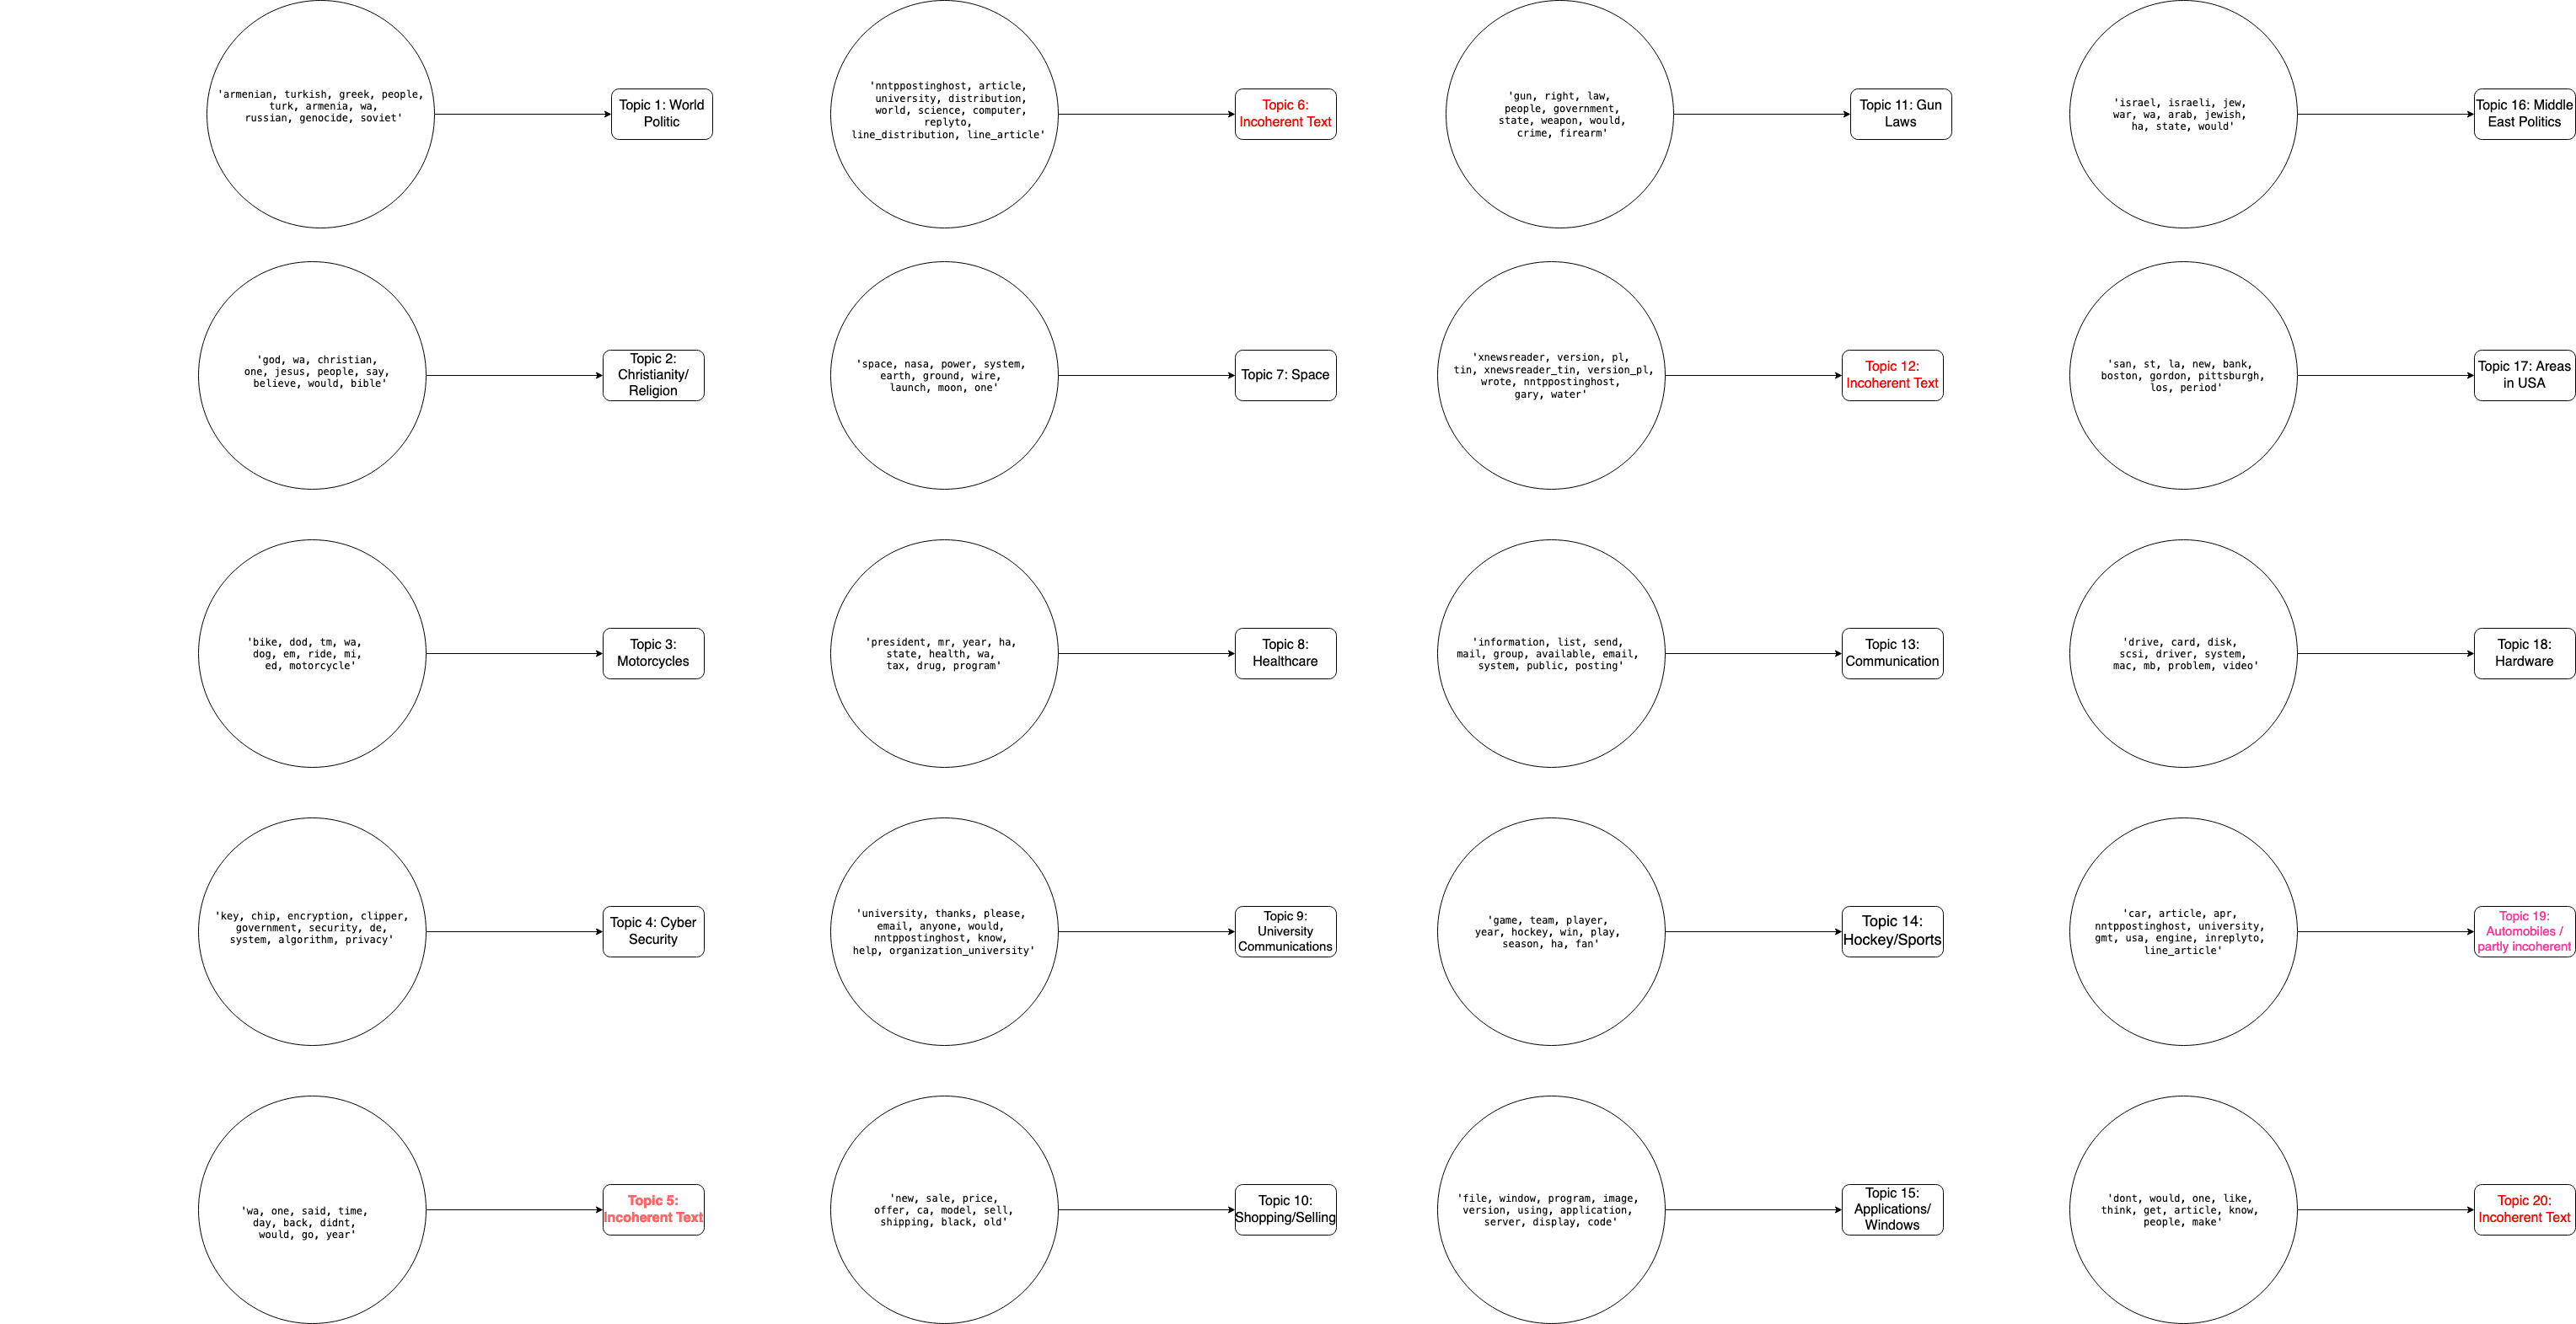

The dataset we chose has some overlap with topics, such as christianity, misc religion and atheism which has not been accurately captured by the model.

Similarly topics like mac hardware, pc hardware, graphics, windows misc and windows x have not been properly demarcated by the model on the basis of the keywords.

There were also some topics with incoherant/random keywords which could not be interpreted as any topic. 

On the other hand, we can also see that there are some topics which were not part of the original dataset and are instead subtopics which has been captured by the LDA model.

With more parameter tuning and given more time, I could possibly fine tune the model to better capture these cases and have more coherant topics.

Things to experiment with to further examine the model:
-------------------------

* When building the dictionary, change ``no_above`` and ``no_below`` parameters in ``filter_extremes`` method.
* Add trigrams and see if it makes a difference.
* Remove bigrams and see if it makes a difference.
* Do not remove stopwords and see if it makes a difference
* Try visualizing with fewer topics to see if that helps to reduce the number of incoherent topics even with the possibility of merging two or more topics into one.
* Try different chunksizes, alpha, eta, values etc while training the model.







References
----------

1. LDA Tutorial. https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
2. Gensim Topic Modelling. https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


